In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
try:
    import empyrical as emp
except:
    emp = None
import tushare as ts
import time
import random

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq
from spider.spider_coinmarketcap import Spider_coinmarketcap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

CONF = Config('../conf/secret.yaml').data[0]
ts_token = CONF['TUSHARE']['TOKEN']
ts.set_token(ts_token)
pro = ts.pro_api()

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
CRYPTOCURRENCY = list(CRYPTOCURRENCY.keys())
NASDAQ100 = CONF['NASDAQ100']

MONITOR_TARGET = {
    '399300': {'MA': [30, 150], 'ROLLINGMAX': [100], 'ROLLINGMIN': [40], 'NAME': '沪深300指数'},
    '000905': {'MA': [90, 120], 'ROLLINGMAX': [30], 'ROLLINGMIN': [20], 'NAME': '中证500指数'},
    '399006': {'MA': [110, 180], 'ROLLINGMAX': [150], 'ROLLINGMIN': [50], 'NAME': '创业板指(SZ:399006)'},
#     '163407': {'MA': [30, 90], 'ROLLINGMAX': [130], 'ROLLINGMIN': [40], 'NAME': '兴全300(SZ:163407)'},
#     '510300': {'MA': [30, 90], 'ROLLINGMAX': [130], 'ROLLINGMIN': [40], 'NAME': '300ETF(SH:510300)'},
#     '512000': {'MA': [30, 90], 'ROLLINGMAX': [130], 'ROLLINGMIN': [40], 'NAME': '券商ETF(SH:512000)'},
#     '512500': {'MA': [], 'ROLLINGMAX': [80], 'ROLLINGMIN': [40], 'NAME': '中证500(SH:512500)'},
#     '161017': {'MA': [110, 120], 'ROLLINGMAX': [40], 'ROLLINGMIN': [170], 'NAME': '161017'},
#     '000516': {'MA': [], 'ROLLINGMAX': [], 'ROLLINGMIN': [], 'NAME': '国际医学(SZ:000516)'},
    'BITCOIN': {'MA': [], 'ROLLINGMAX': [20], 'ROLLINGMIN': [10], 'NAME': 'BITCOIN'},
    'EOS': {'MA': [], 'ROLLINGMAX': [20], 'ROLLINGMIN': [10], 'NAME': 'EOS'},
}

pd

<module 'pandas' from '/usr/local/lib/python3.6/site-packages/pandas/__init__.py'>

In [2]:
%%time

IS_DOWNLOAD_DATA = True

spider_n = Spider_nasdaq()
spider_c = Spider_coinmarketcap()

for symbol in MONITOR_TARGET:
    if not IS_DOWNLOAD_DATA:
        break
        
    print(symbol)

    # 指数
    if symbol in ['399300', '000905', '000016', '399006']:
        df = ts.get_k_data(code=symbol, index=True, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        
    # CRYPTOCURRENCY
    elif symbol in CRYPTOCURRENCY:
        datafile = spider_c.get_coin_data(symbol, start_date='20100101', end_date=time.strftime('%Y%m%d'))
        
    # ETF
    else:
        df = ts.get_k_data(code=symbol, ktype='D', autype='qfq', index=False, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        time.sleep(1)

#         if symbol.startswith('00') or symbol.startswith('30'):
#             temp_symbol = '%s.SZ' % symbol
#         elif symbol.startswith('60'):
#             temp_symbol = '%s.SH' % symbol
#         df = pro.daily_basic(ts_code=temp_symbol, start_date='20050101', end=time.strftime('%Y%m%d'))
#         datafile = '../database/market/%s_pro_daily_basic.csv' % symbol
#         df.to_csv(datafile, index=False, encoding='utf-8')
        
#     print(datafile)
    time.sleep(1)

399300
000905
399006
BITCOIN
EOS
CPU times: user 30.2 s, sys: 258 ms, total: 30.5 s
Wall time: 57 s


In [3]:
%%time

stock_df_dict = {}

for symbol in MONITOR_TARGET:
    stock_data_file = '../database/market/%s.csv' % symbol
    try:
        stock_df = pd.read_csv(stock_data_file)
    except:
        print(symbol)
        continue

    # 筛选字段
#     stock_df = stock_df.loc[:, ['date', 'open', 'close']]
    stock_df = stock_df.loc[:, ['date', 'open']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ100:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    if symbol in NASDAQ100 or symbol in CRYPTOCURRENCY:
        stock_df = stock_df[::-1]
    stock_df.set_index(['date'], inplace=True)
    stock_df.index = stock_df.index.to_period('D')

    # 计算每天涨跌幅
#     stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
#     stock_df['pre_close'] = stock_df.close.shift(1)
#     stock_df['c_o_pct_chg'] = (stock_df.open - stock_df.pre_close) / stock_df.pre_close
#     stock_df['c_o_pct_chg'] = (stock_df.open - stock_df.close.shift(1)) / stock_df.close.shift(1)
    
    # Turtle指标
#     stock_df['TR1'] = abs(stock_df['high'] - stock_df['low'])
#     stock_df['TR2'] = abs(stock_df['high'] - stock_df['close'].shift())
#     stock_df['TR3'] = abs(stock_df['low'] - stock_df['close'].shift())
#     stock_df['TR'] = stock_df[['TR1', 'TR2', 'TR3']].max(axis=1)
#     stock_df['N'] = stock_df['TR'].rolling(20).mean()
#     stock_df['UNIT'] = (0.01 * START_MONEY) / (stock_df['N'])
#     stock_df['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N] = stock_df['open'].rolling(TURTLE_SHORT_BUY_N).max()
#     stock_df['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N] = stock_df['open'].rolling(TURTLE_SHORT_SELL_N).min()
#     stock_df['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N] = stock_df['open'].rolling(TURTLE_LONG_BUY_N).max()
#     stock_df['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N] = stock_df['open'].rolling(TURTLE_LONG_SELL_N).min()
#     stock_df['EWMA'] = stock_df['open'].ewm(alpha=0.1, adjust=False).mean()

#     MONITOR_TARGET[symbol]['MA']
    for MA_PARAM in MONITOR_TARGET[symbol]['MA']:
#         print(MA_PARAM)
        stock_df['MA_%d' % MA_PARAM] = stock_df['open'].rolling(MA_PARAM).mean()
    
    for ROLLINGMAX_PARAM in MONITOR_TARGET[symbol]['ROLLINGMAX']:
        stock_df['ROLLINGMAX_%d' % ROLLINGMAX_PARAM] = stock_df['open'].rolling(ROLLINGMAX_PARAM).max()
        
    for ROLLINGMIN_PARAM in MONITOR_TARGET[symbol]['ROLLINGMIN']:
        stock_df['ROLLINGMIN_%d' % ROLLINGMIN_PARAM] = stock_df['open'].rolling(ROLLINGMIN_PARAM).min()
    
    # 减少数据
    # stock_df = stock_df['2016-01-01':]
    stock_df.dropna(how='any', inplace=True)
    
    stock_df_dict[symbol] = stock_df

CPU times: user 2.24 s, sys: 7 ms, total: 2.25 s
Wall time: 2.25 s


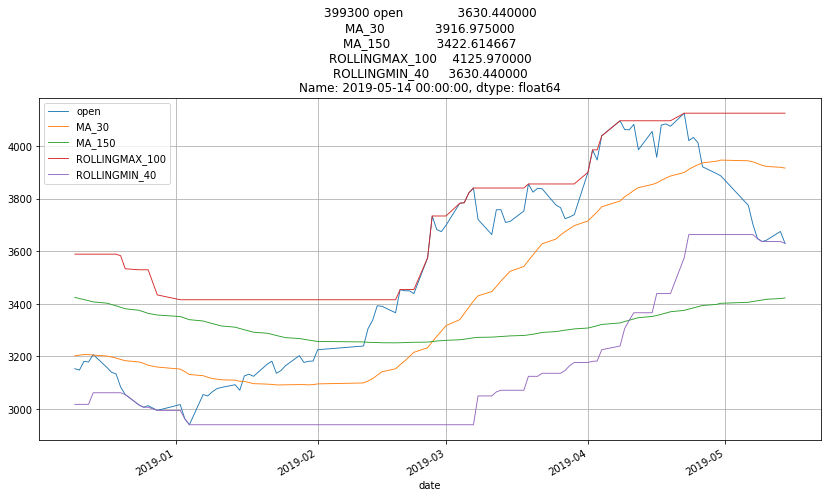

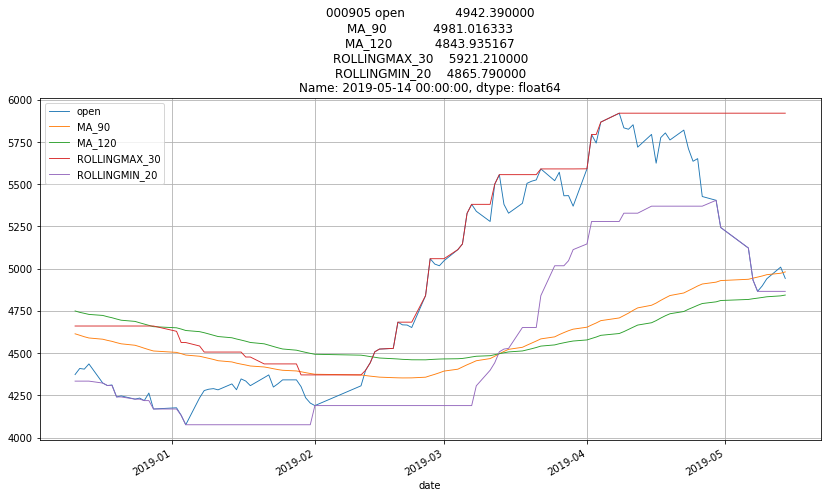

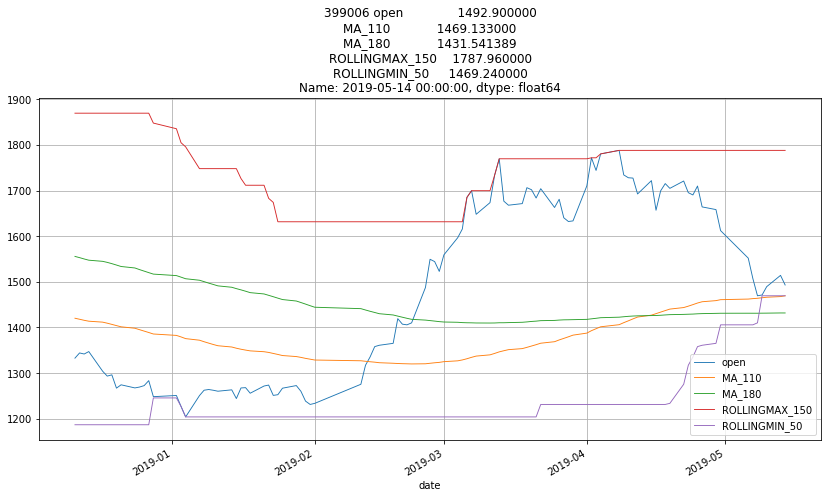

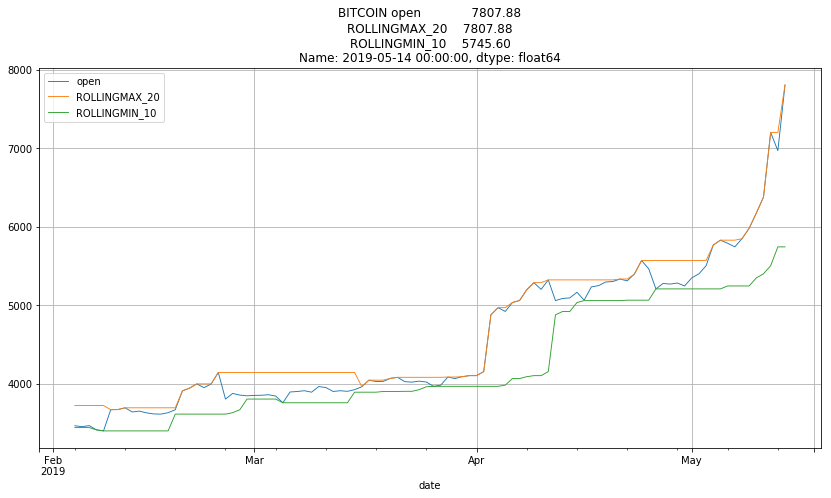

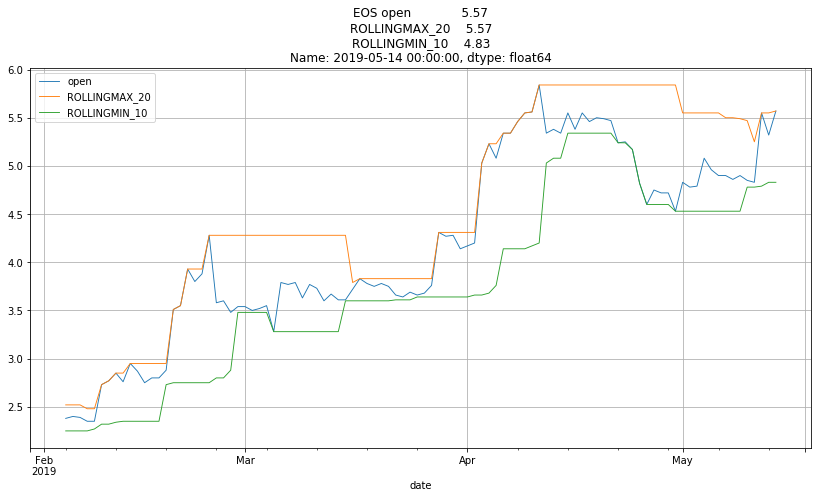

In [20]:
for symbol in MONITOR_TARGET:
#     symbol, MONITOR_TARGET[symbol]
    df = stock_df_dict[symbol].iloc[-100:].copy()
#     df.columns
#     df.head(2)
#     df.tail(2)

#     len(df), len(df[df['open'] > df.iloc[-1].open])
#     len(df[df['open'] > df.iloc[-1].open]) / len(df)
    
    df.reset_index(drop=False, inplace=True)
    # df = df.astype(dtype={'date': 'datetime64[ns]'})
    df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
    df.set_index('date', inplace=True)
    # ax = df.plot(kind='line', y='close', label='test', linewidth=1, grid=True)
    # y = []

    title = '%s %s' % (symbol, MONITOR_TARGET[symbol]['NAME'])
    title = '%s %s' % (symbol, df.iloc[-1])
    
#     display_charts(df, chart_type='stock', kind='line', title=title,
#                    figsize=(1000, 600))
    
    ax = df.plot(kind='line', title=title, linewidth=0.9, grid=True, figsize=(14, 7))

In [19]:
# df = ts.get_realtime_quotes(['sh', 'sz', 'hs300', 'sz50', 'sh000905', 'zxb', 'cyb'])
# df = ts.get_realtime_quotes(MONITOR_TARGET)
list(MONITOR_TARGET.keys())

['399300', '000905', '399006', 'BITCOIN', 'EOS']

In [14]:
df

,name,open,pre_close,price,high,low,bid,ask,volume,amount,...,a2_p,a3_v,a3_p,a4_v,a4_p,a5_v,a5_p,date,time,code
0,上证指数,2902.6423,2883.6107,2938.6781,2945.3946,2902.6423,0,0,230519701,226262785583,...,0,,0,,0,,0,2019-05-15,15:01:54,000001
1,深证成指,9125.268,9038.364,9259.029,9282.965,9123.904,0.000,0.000,28889591726,286522186673.543,...,0.000,,0.000,,0.000,,0.000,2019-05-15,15:00:03,399001
2,沪深300,3674.9931,3645.1503,3727.0923,3741.0406,3674.9931,0,0,110161769,152534546781,...,0,,0,,0,,0,2019-05-15,15:01:54,000300
3,上证50,2743.7809,2724.7337,2783.5439,2797.1531,2743.7809,0,0,30718920,47008658100,...,0,,0,,0,,0,2019-05-15,15:01:54,000016
4,中证500,5002.6051,4965.6124,5076.5550,5086.7298,4999.3368,0,0,97463860,88150026771,...,0,,0,,0,,0,2019-05-15,15:01:54,000905
5,中小板指,5626.726,5570.416,5700.070,5713.905,5626.726,0.000,0.000,2437202169,32635627851.300,...,0.000,,0.000,,0.000,,0.000,2019-05-15,15:00:03,399005
6,创业板指,1509.452,1494.603,1528.691,1533.728,1503.672,0.000,0.000,7086525638,81620246867.350,...,0.000,,0.000,,0.000,,0.000,2019-05-15,15:00:03,399006
